In [1]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")

# Print GPU details
for i, gpu in enumerate(gpus):
    print(f"GPU {i}: {gpu}")

# Assuming 'GPU:1' is the identifier for the second GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Disable first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Logical GPUs:", logical_gpus)
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

2024-06-26 17:37:49.939060: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPUs found: 3
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
GPU 2: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2024-06-26 17:37:52.259256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 17:37:52.976437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21532 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:18:00.0, compute capability: 8.6


In [2]:
from orbit_generation.visualize import visualize_static_orbits, plot_latent_space_2d
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.experiment import get_experiment_parameters

In [3]:
import numpy as np
import tsgm
import os

2024-06-26 17:37:55.525150: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-26 17:37:55.527061: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7d97970


# Get full latent space

In [4]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = r'../experiments'
experiment_folder = r'../experiments/experiment_1'
experiment_id = int(experiment_folder[-1])

In [5]:
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_data.npy')
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
latent_deviations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_deviations.npy')
labels_path = os.path.join(experiment_folder, f'exp{experiment_id}_labels.npy')
latent_space_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_space')

In [6]:
params=get_experiment_parameters(experiments_folder=experiments_folder, experiment_id=experiment_id)

data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 300)

In [7]:
# Set a random seed for reproducibility
np.random.seed(42) 

# Create an array of indices based on the length of the data
indices = np.arange(data.shape[0])

# Shuffle the indices
np.random.shuffle(indices)

# Use the shuffled indices to reorder the data and labels
data = data[indices]
labels = np.array(labels)
labels = labels[indices]

transposed_orbits = np.transpose(data, (0, 2, 1))

scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(transposed_orbits)
del transposed_orbits
scaled_data.shape

(45211, 300, 7)

In [9]:
if params['model_name']=='vae_conv5':
    encoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_encoder')
    decoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_decoder')
    encoder = tf.keras.models.load_model(encoder_save_path)
    decoder = tf.keras.models.load_model(decoder_save_path)
    model = tsgm.models.cvae.BetaVAE(encoder, decoder)
else:
    model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model')
    model = tf.keras.models.load_model(model_save_path)

In [10]:
latent_mean, latent_deviation, latent_epsilon = model.encoder(scaled_data)
latent_representations = latent_mean.numpy()

np.save(latent_representations_path, latent_representations)
np.save(latent_deviations_path, latent_deviation)
np.save(labels_path, labels)

latent_representations.shape

2024-06-26 17:39:30.150512: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


(45211, 2)

In [11]:
id_classes = [orbit_df.at[index, 'id_class'] for index in labels]
classes=get_orbit_classes(id_classes)

Saved plot to ../experiments/experiment_1/exp1_latent_space_label


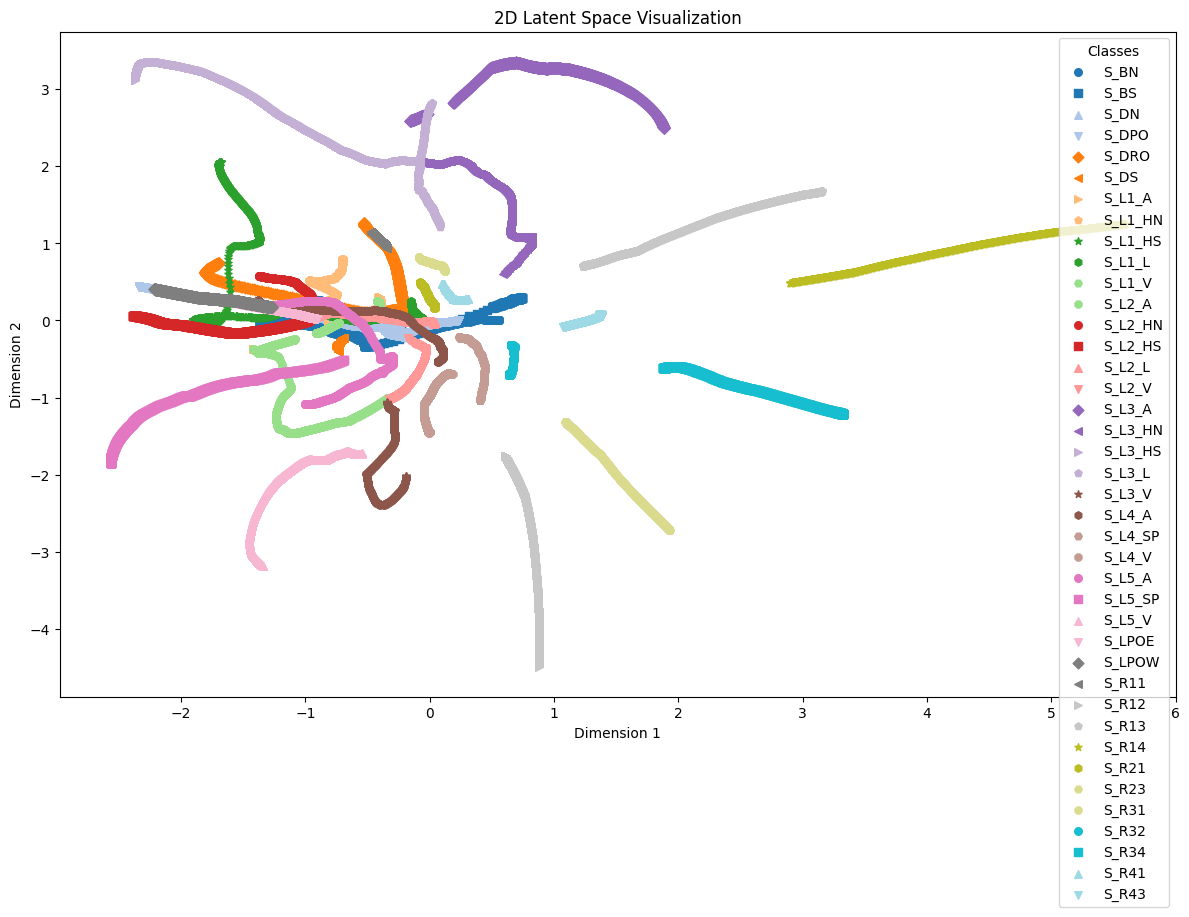

Saved plot to ../experiments/experiment_1/exp1_latent_space_type


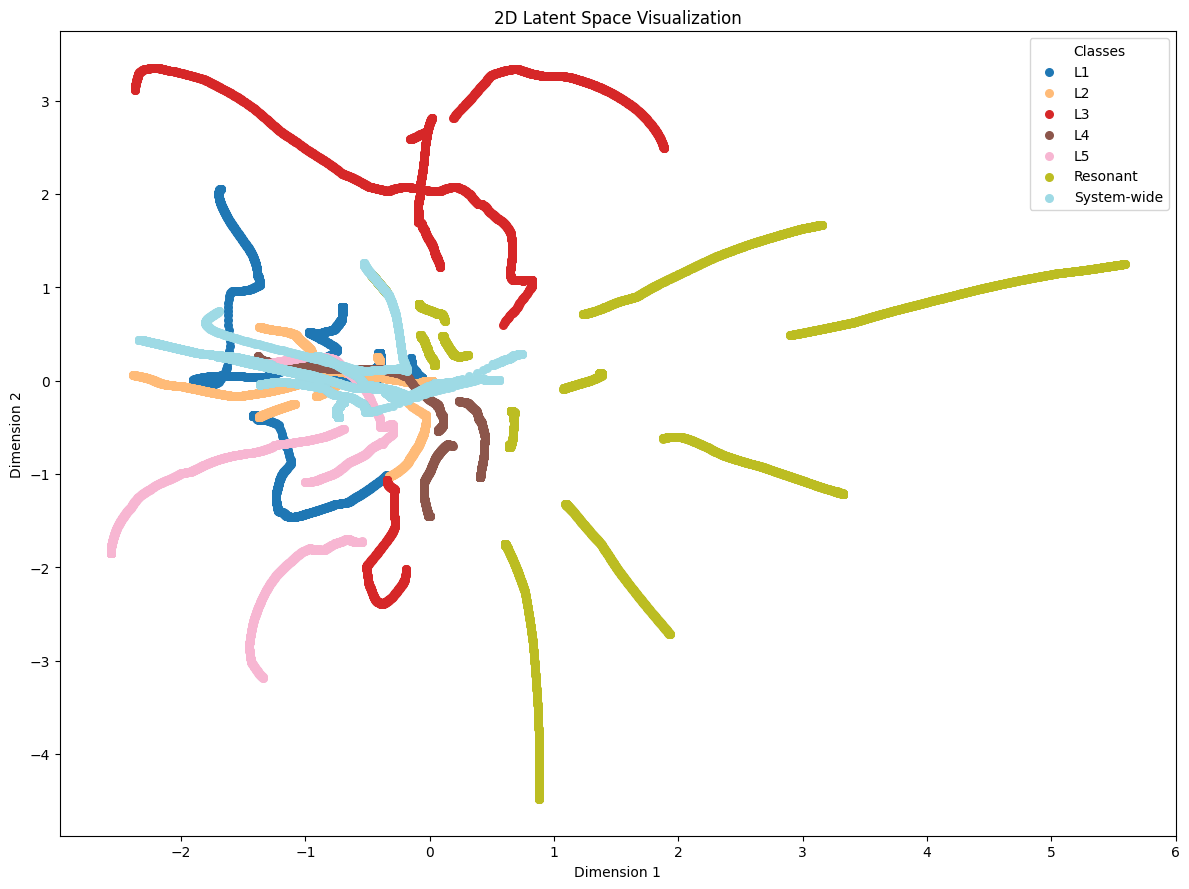

Saved plot to ../experiments/experiment_1/exp1_latent_space_subtype


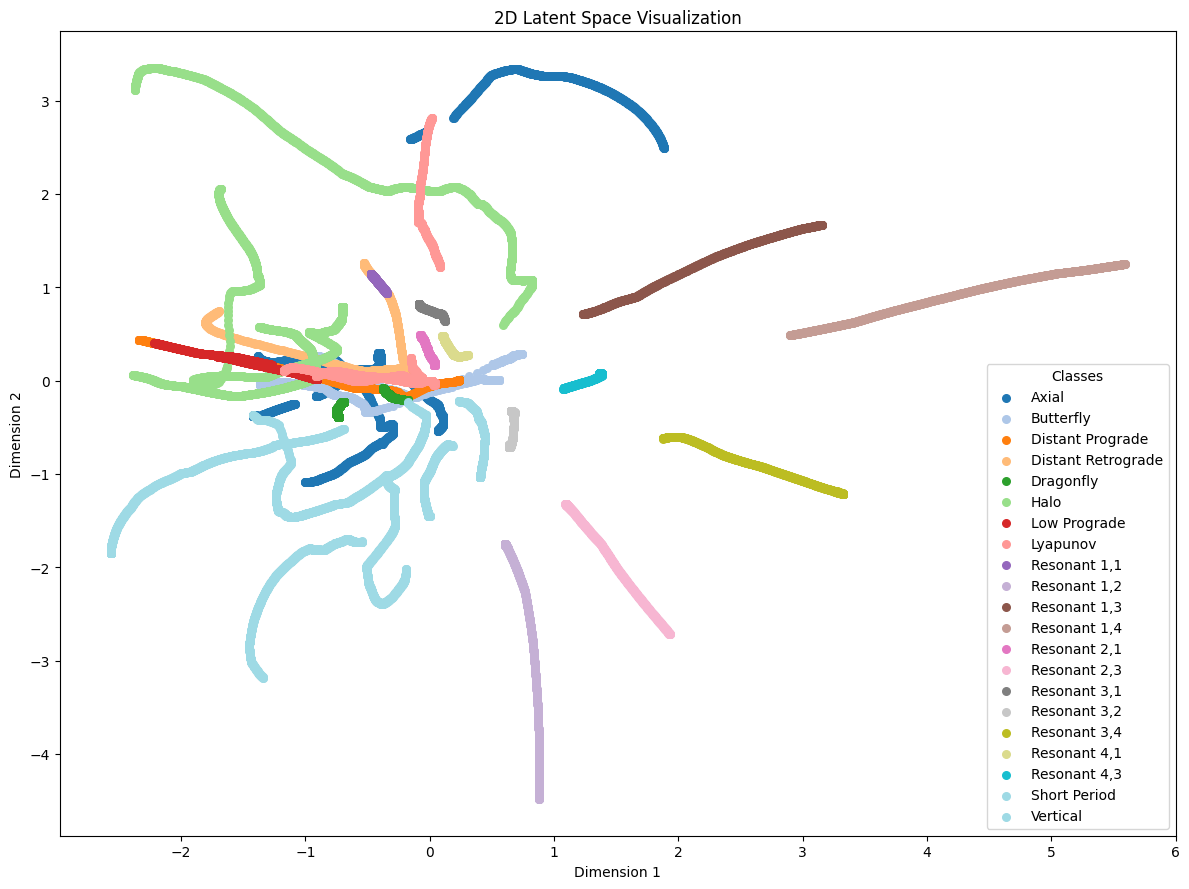

Saved plot to ../experiments/experiment_1/exp1_latent_space_direction


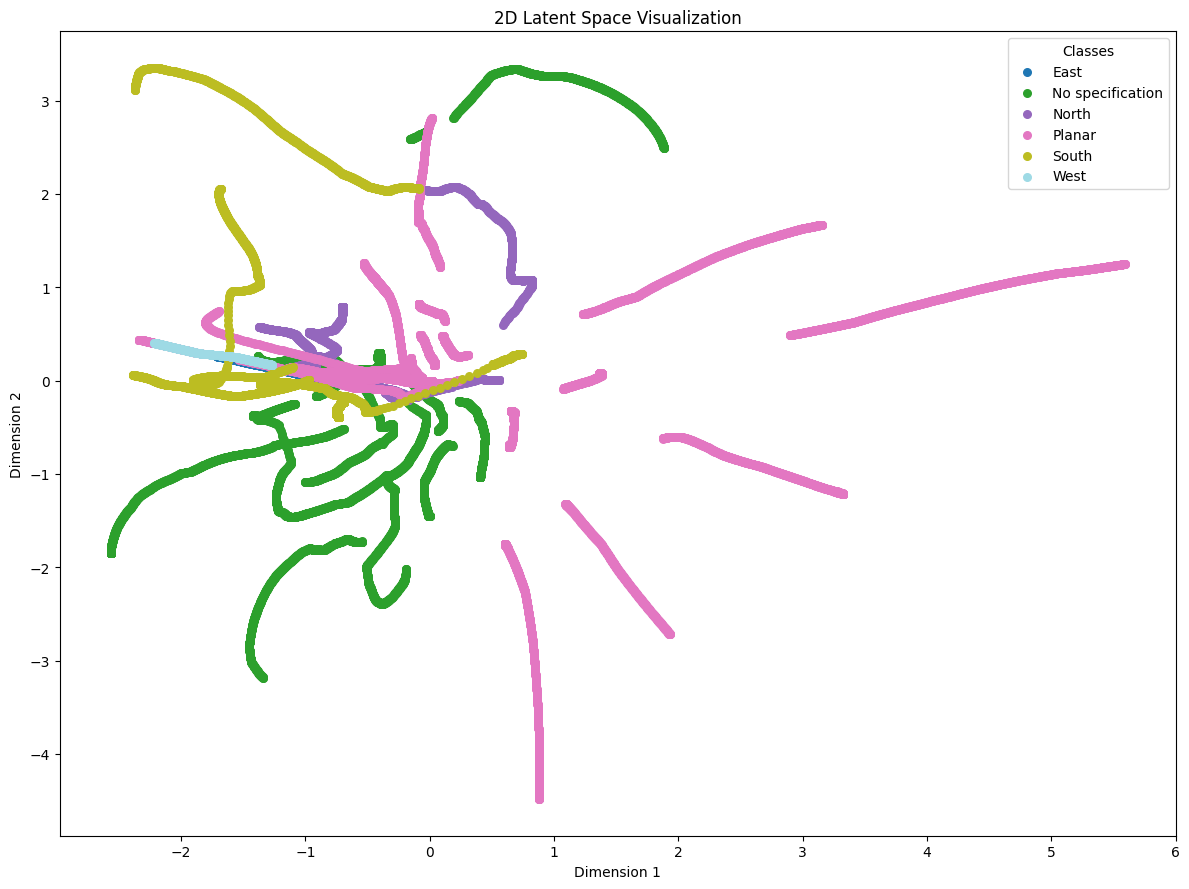

In [14]:
if latent_representations.shape[1]==2:
    plot_latent_space_2d(latent_representations, np.array(classes[0]), save_path=latent_space_path +'_label', many_classes=True)
    plot_latent_space_2d(latent_representations, np.array(classes[1]), save_path=latent_space_path +'_type')
    plot_latent_space_2d(latent_representations, np.array(classes[2]), save_path=latent_space_path +'_subtype')
    plot_latent_space_2d(latent_representations, np.array(classes[3]), save_path=latent_space_path +'_direction')

In [13]:
klk

NameError: name 'klk' is not defined

# Next

In [ ]:

initial_conditions_file = r'/orbit-generation/data/generated_converged_data/corrected_initial_conditions.npy'
generated_data_4_file = r'/orbit-generation/data/generated_converged_data/generated_data_experiment_4.npy'

In [ ]:
initial_conditions = np.load(initial_conditions_file)
initial_conditions.shape

(39, 9)

In [ ]:
initial_conditions[0]

array([ 4.00000000e+00,  8.00000000e+00,  6.14963007e+00, -1.00506265e+00,
       -6.45547890e-14, -5.80359305e-16, -3.62205749e-14,  5.35171892e-14,
        5.18316560e-17])

In [ ]:
columns= ['id','iterations_convergence','period','pos_x0','pos_y0','pos_z0','vel_x0','vel_y0','vel_z0']

In [ ]:
generated_data = np.load(generated_data_4_file)
generated_data.shape

(100, 300, 7)

In [ ]:
if generated_data.shape[2] == 7:
    inverted2_generation = generated_data[:,:,1:]
    inverted2_generation.shape
else:
    inverted2_generation = generated_data

display_generation = np.transpose(inverted2_generation, (0, 2, 1))
display_generation.shape

(100, 6, 300)

In [ ]:
display_generation[0].shape

(6, 300)

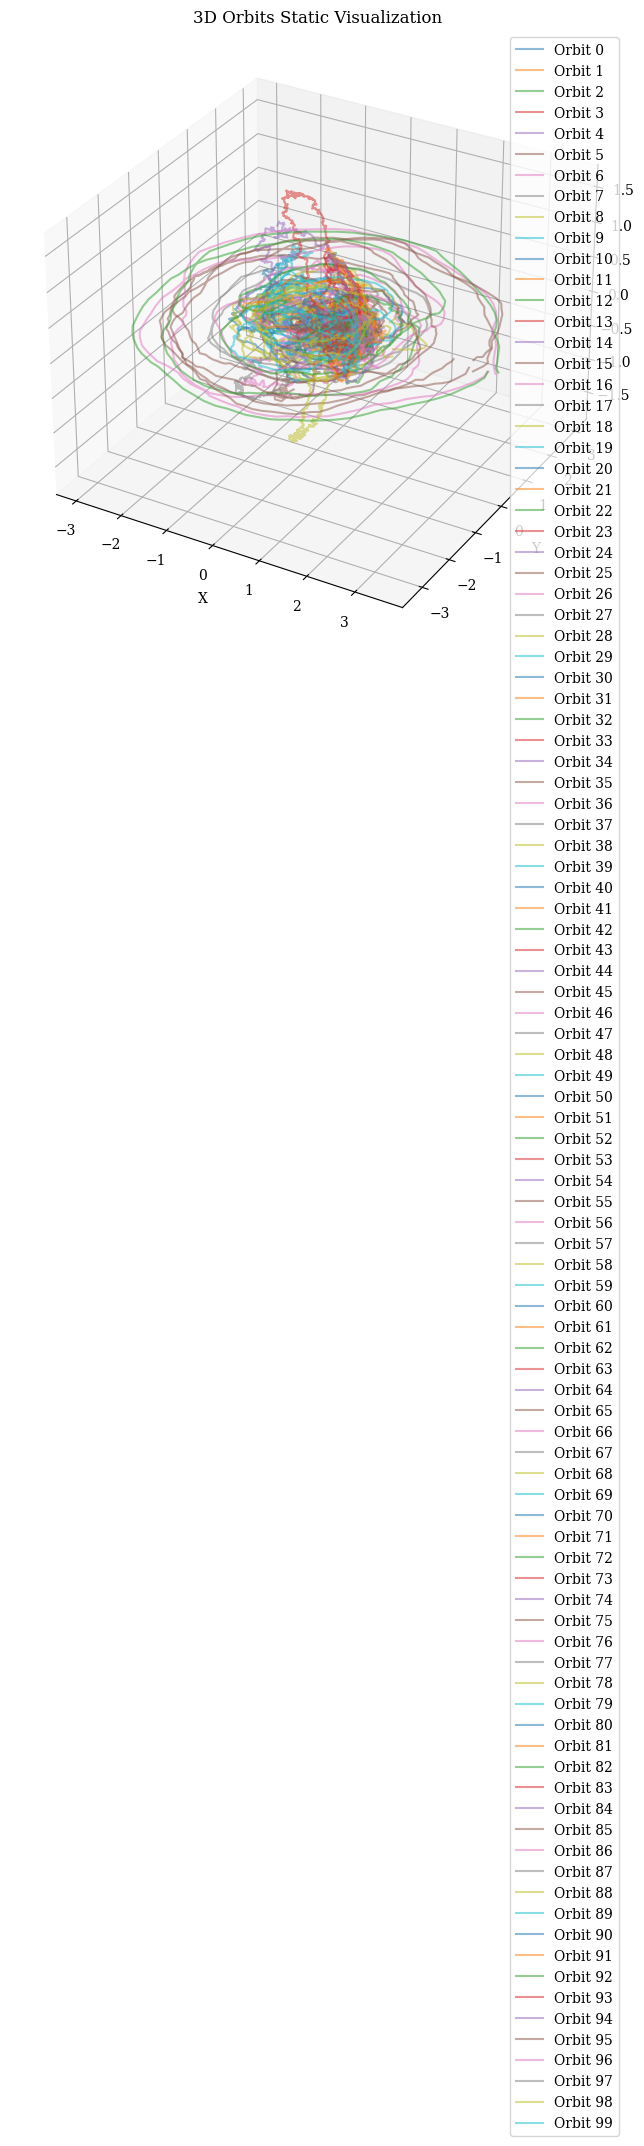

In [ ]:
visualize_static_orbits(display_generation, show_legend=False)